<h1 align="center">UST, Zewail City</h1>
<h2 align="center">CIE 555 (Spring 2022)</h2>
<h2 align="center">Lab 8: Time Series Forecasting</h2>
<h2 align="center">Anhar Hassan</h2>



Based on prev. work by Eng. Aya Elzay

and on Tensorflow and Keras tutorials: 



https://www.tensorflow.org/tutorials/structured_data/time_series 

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

#Lab Objectives

* Explore and process the weather time series data
* Understand the basic operations of RNN models and LSTM cells
* Use RNNs for time series forecasting
* Get introduced to the concept of autoregressive models

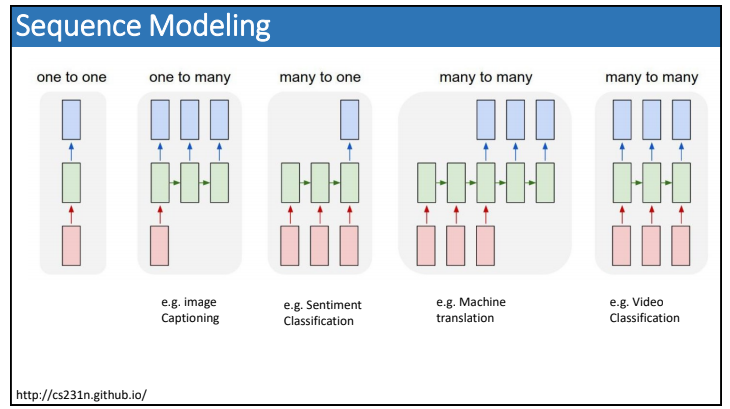

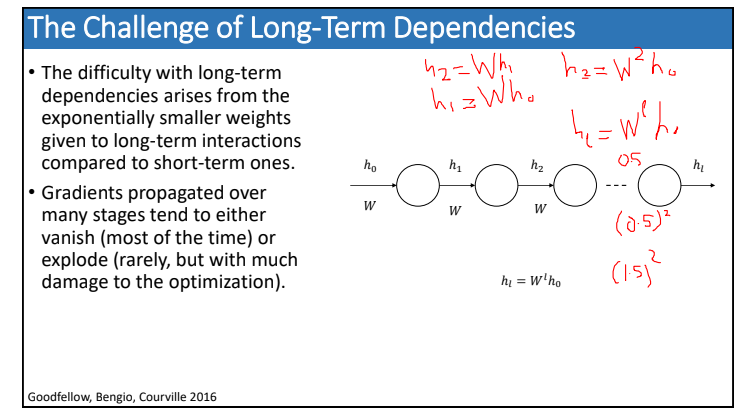

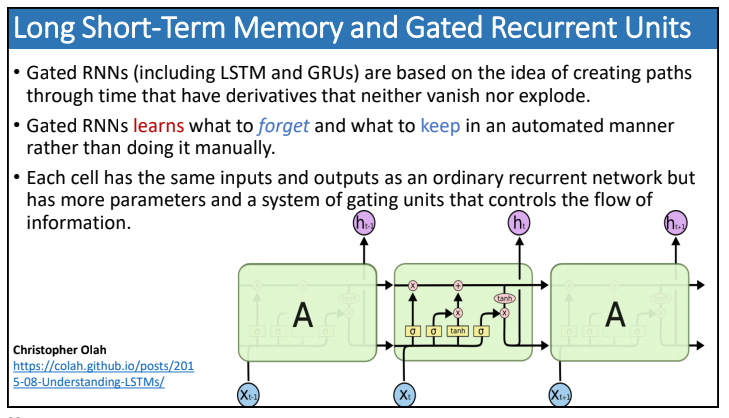

#Installation and Import statements

In [10]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

     - 25.9 MB 705 kB/s
     |████████████████████████████████| 10.9 MB 11.7 MB/s 
     |████████████████████████████████| 596 kB 41.1 MB/s 
     |████████████████████████████████| 102 kB 12.1 MB/s 
     |████████████████████████████████| 690 kB 41.2 MB/s 
     |████████████████████████████████| 4.7 MB 48.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 812 kB 42.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.2.0-py2.py3-none-any.whl size=262611 sha256=7efc8aaa2fe6eed46b695021958cf5e8917b1ac5ffe916a443c3cdea5309b4c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-fhcmrkzq/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=7ebcf0a186a4d4a8bfa608bf9cda0088ef566c5883a236c257e9879a072375ce
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b1

In [11]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from zipfile import ZipFile
from keras.layers import SimpleRNN, GRU, Dense, Input, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

#Dataset

* In this lab we will work with the weather forecasting dataset.
* This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. 
* These were collected every 10 minutes, beginning in 2003. 
* We will use only the data collected between 2009 and 2016. 

In [13]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [14]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


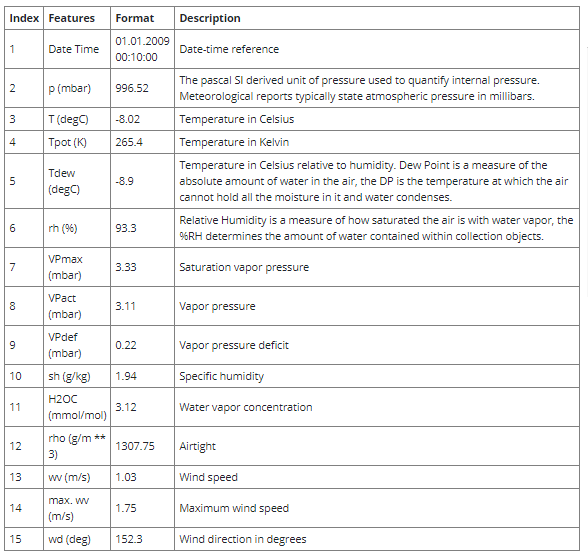

#Data Cleaning and Feature Engineering

##Drop some of the highly correlated features

We'll drop the following features: 
* Tpot (K)
* Tdew (degC) 
* rh
* VPact (mbar)
* max. wv (m/s)
* H2OC 

In [15]:
df= df.drop(columns=['Tpot (K)','Tdew (degC)','rh (%)','VPact (mbar)','max. wv (m/s)', 'H2OC (mmol/mol)'])
df.head()

,Date Time,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,1.03,152.3
1,01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,0.72,136.1
2,01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,0.19,171.6
3,01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,0.34,198.0
4,01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,0.32,214.3


In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
rho (g/m**3),420551.0,1216.062748,39.975208,1059.45,1187.49,1213.79,1242.77,1393.54
wv (m/s),420551.0,1.702224,65.446714,-9999.00,0.99,1.76,2.86,28.49
wd (deg),420551.0,174.743738,86.681693,0.00,124.90,198.10,234.10,360.00


##Wind Velocity Min Value

One thing that should stand out is the min value of the wind velocity, wv (m/s) column. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:

In [17]:
bad_wv = df['wv (m/s)'] == -9999.0
df['wv (m/s)'][bad_wv] = 0.0
df.describe().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
rho (g/m**3),420551.0,1216.062748,39.975208,1059.45,1187.49,1213.79,1242.77,1393.54
wv (m/s),420551.0,2.130191,1.542334,0.00,0.99,1.76,2.86,28.49
wd (deg),420551.0,174.743738,86.681693,0.00,124.90,198.10,234.10,360.00


##Wind Direction

The last column of the data, wd (deg), gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. It will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind vector:
 

In [18]:
wv = df.pop('wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi/180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)
df.head()

,Date Time,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),Wx,Wy
0,01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,-0.911955,0.478787
1,01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,-0.518797,0.499249
2,01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,-0.187962,0.027756
3,01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,-0.323359,-0.105066
4,01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,-0.264351,-0.180328


In [19]:
features= df.drop(columns='Date Time')
features.index=df['Date Time']
features.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),Wx,Wy
Date Time,,,,,,,,
01.01.2009 00:10:00,996.52,-8.02,3.33,0.22,1.94,1307.75,-0.911955,0.478787
01.01.2009 00:20:00,996.57,-8.41,3.23,0.21,1.89,1309.80,-0.518797,0.499249
01.01.2009 00:30:00,996.53,-8.51,3.21,0.20,1.88,1310.24,-0.187962,0.027756
01.01.2009 00:40:00,996.51,-8.31,3.26,0.19,1.92,1309.19,-0.323359,-0.105066
01.01.2009 00:50:00,996.51,-8.27,3.27,0.19,1.92,1309.00,-0.264351,-0.180328


##Split the data

* Label column name: ['T (degC)']
 
* Here we are picking ~300,000 data points for training. Observation is recorded every 10 mins, that means 6 times per hour. We will resample one point per hour since no drastic change is expected within 60 minutes. We do this via the sampling_rate argument in timeseries_dataset_from_array utility.

* We are tracking data from past 36 timestamps (36/6=6 hours). This data will be used to predict the temperature after 6 timestamps (6/6=1 hour).

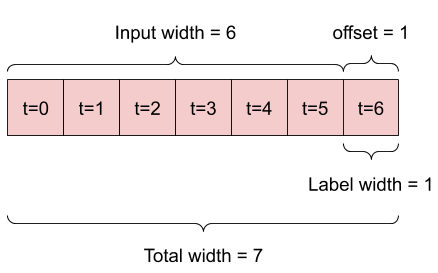

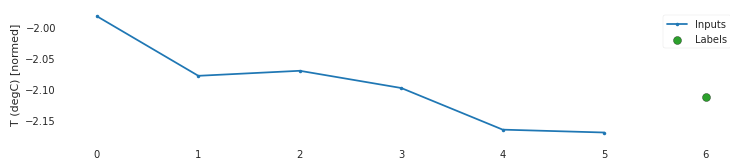

For example, to make a single prediction 24h into the future, given 24h of history you might define a window like this:

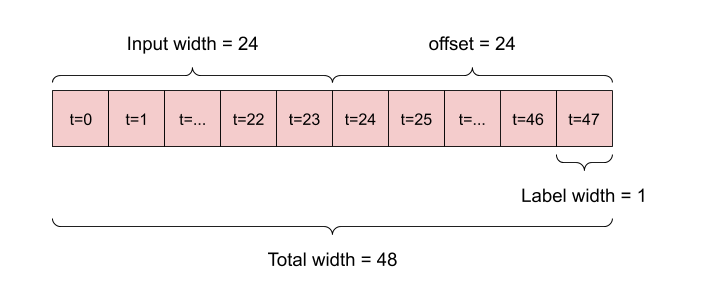

In [20]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [21]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
print("Train split: ", train_split)
step = 6
past = 36
future = 6
learning_rate = 0.001
batch_size = 256
epochs = 10

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

Train split:  300693


,0,1,2,3,4,5,6,7
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.160517,0.560861
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,0.035423,0.574009
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,0.200303,0.271053
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,0.132824,0.185709
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,0.162232,0.137350


In [22]:
train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

print("Train data shape: ", train_data.shape)
print("Validation data shape: ", val_data.shape)

Train data shape:  (300693, 8)
Validation data shape:  (119858, 8)


In [25]:
start = past + future

end = start + train_split
x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = int(past / step)
print("Sequence length =", sequence_length)

Sequence length = 6


The timeseries_dataset_from_array function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, spacing between two sequence/windows, etc., to produce batches of sub-timeseries inputs and targets sampled from the main timeseries.

**tf.keras.preprocessing.timeseries_dataset_from_array(
    data, targets, sequence_length, sampling_rate=1,
    batch_size=128, shuffle=False, seed=None, start_index=None, end_index=None
)**



* data:	Numpy array or eager tensor containing consecutive data points (timesteps). Axis 0 is expected to be the time dimension.
* targets:	Targets corresponding to timesteps in data. It should have same length as data. targets[i] should be the target corresponding to the window that starts at index i 
* sequence_length	Length of the output sequences (in number of timesteps).

In [26]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

##Validation data

We'll exclude the last 6 hours from the validation data because we don't have a label for them

In [27]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [28]:
for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 6, 8)
Target shape: (256, 1)


#Training

In [29]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 8)]            0         
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [30]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10


KeyboardInterrupt: ignored

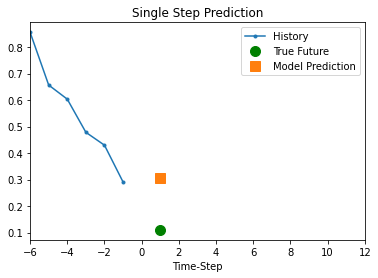

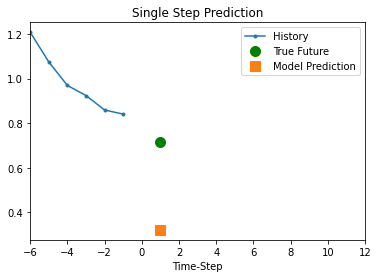

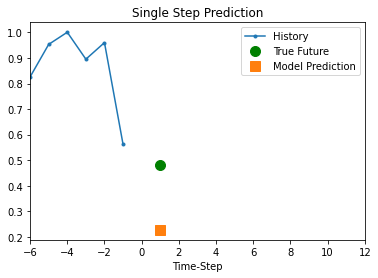

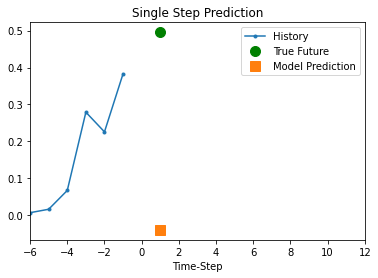

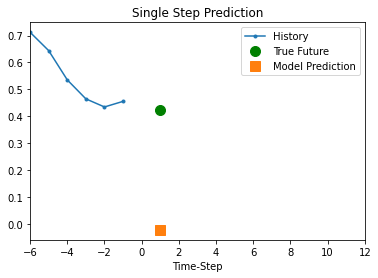

In [31]:
%matplotlib inline
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "go", "s"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    
    plt.title(title)
    for i, val in enumerate(plot_data):
      if i:
        plt.plot(delta, plot_data[i], marker[i], markersize=10, label=labels[i])
      else:
        plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (delta + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

#multi-step prediction with Autoregressive models

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

Single shot predictions where the entire time series is predicted at once.
Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

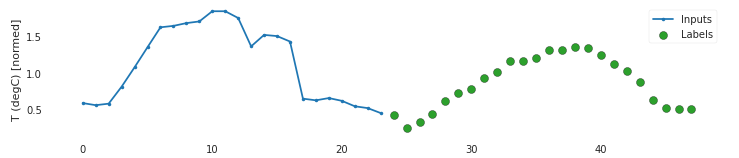

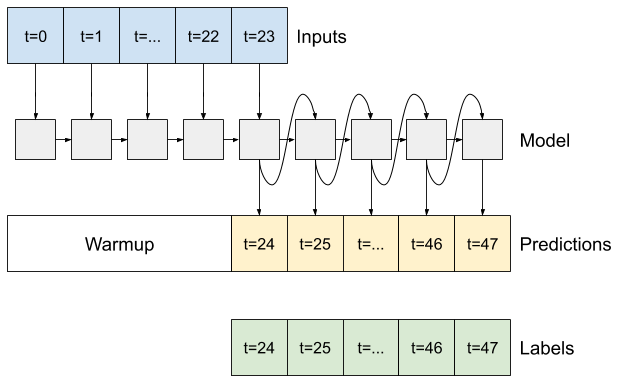

#Task [10 points]

Use two RNN models (one with simple vanilla RNN cells, other with GRU cells) to predict the temperature 6 hours into the future given the past 12 hours:


https://keras.io/api/layers/recurrent_layers/simple_rnn/

https://keras.io/api/layers/recurrent_layers/gru/

- In this task you're required to split the data into training, validation and test. [2 points] Use the test set to test the generalization error of your models.[3 points each] 
- Use mean absolute error as an evaluation metric [1 point]
- Compare the performance of the two models and comment on the results [1 points]
- At least one of them MUST contain more than a single RNN layer; {Hint: check return_sequence parameter in the RNN layers documentation to help you in that.}


# Splitting the Data into train,validation, and test sets 

In [32]:

train_split = 0.5
val_split = 0.2
test_split = 0.3
num_train_samples = int(train_split * df.shape[0])
num_val_samples = int(val_split * df.shape[0])
num_test_samples = len(df) - num_train_samples - num_val_samples

learning_rate = 1e-5
batch_size = 256
epochs = 10

step = 6
past = 72
future = 36

features = normalize(features.values, num_train_samples)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7
0,0.913803,-1.920805,-1.291346,-0.782385,-1.470125,2.124368,-0.126712,0.615229
1,0.919682,-1.965274,-1.304503,-0.784482,-1.489118,2.173138,0.070466,0.628581
2,0.914978,-1.976677,-1.307134,-0.786579,-1.492917,2.183605,0.236386,0.320909
3,0.912627,-1.953872,-1.300556,-0.788676,-1.477722,2.158626,0.168482,0.234236
4,0.912627,-1.949311,-1.299240,-0.788676,-1.477722,2.154106,0.198075,0.185124


In [33]:
train_data = features.loc[0 : num_train_samples-1]
val_data = features.loc[num_train_samples:num_train_samples+num_val_samples]
test_data = features.loc[num_train_samples+num_val_samples:]

print("Train data shape: ", train_data.shape)
print("Validation data shape: ", val_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (210275, 8)
Validation data shape:  (84111, 8)
Test data shape:  (126166, 8)


In [34]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(x_train, y_train, sequence_length = sequence_length, sampling_rate = step, batch_size = batch_size)

In [35]:
x_end = len(val_data) 
label_start = num_train_samples + past + future

x_val = val_data.iloc[:x_end].values
y_val = features.iloc[label_start:label_start+num_val_samples+1][[1]]


In [36]:
dataset_validation = keras.preprocessing.timeseries_dataset_from_array(x_val, y_val, sequence_length = sequence_length, sampling_rate = step, batch_size = batch_size)

In [37]:
x_end = len(test_data) 
label_start = num_train_samples 

x_test = test_data.iloc[:x_end].values
y_test = features.iloc[label_start+num_val_samples:][[1]]


In [38]:
dataset_test = keras.preprocessing.timeseries_dataset_from_array(x_test, y_test, sequence_length = sequence_length, sampling_rate = step, batch_size = batch_size)

In [39]:

for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 6, 8)
Target shape: (256, 1)


###  RNN

In [40]:

inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
x = SimpleRNN(8, return_sequences=True)(inputs)
x = SimpleRNN(8, return_sequences=True)(x)
output = SimpleRNN(8)(x)

model = keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 8)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 6, 8)              136       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 6, 8)              136       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 8)                 136       
                                                                 
Total params: 408
Trainable params: 408
Non-trainable params: 0
_________________________________________________________________


In [41]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
history = model.fit(dataset_train, epochs = epochs, validation_data = dataset_val, callbacks = [early_stopping] )

Epoch 1/10
1175/1175 [==============================] - 105s 87ms/step - loss: 0.3245 - mae: 0.4082 - val_loss: 0.1524 - val_mae: 0.2763
Epoch 2/10
1175/1175 [==============================] - 97s 83ms/step - loss: 0.1744 - mae: 0.2782 - val_loss: 0.1294 - val_mae: 0.2445
Epoch 3/10
1175/1175 [==============================] - 99s 85ms/step - loss: 0.1622 - mae: 0.2582 - val_loss: 0.1281 - val_mae: 0.2458
Epoch 4/10
1175/1175 [==============================] - 98s 84ms/step - loss: 0.1592 - mae: 0.2523 - val_loss: 0.1282 - val_mae: 0.2476
Epoch 5/10
1175/1175 [==============================] - 97s 82ms/step - loss: 0.1579 - mae: 0.2497 - val_loss: 0.1270 - val_mae: 0.2457
Epoch 6/10
1175/1175 [==============================] - 97s 83ms/step - loss: 0.1571 - mae: 0.2479 - val_loss: 0.1263 - val_mae: 0.2446
Epoch 7/10
1175/1175 [==============================] - 98s 83ms/step - loss: 0.1565 - mae: 0.2465 - val_loss: 0.1261 - val_mae: 0.2443
Epoch 8/10
1175/1175 [=========================

In [42]:
model.evaluate(dataset_test)

493/493 [==============================] - 22s 43ms/step - loss: 0.2724 - mae: 0.3976


[0.2724139988422394, 0.3975636661052704]

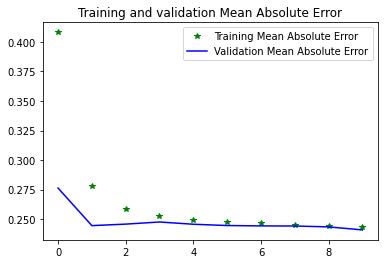

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = np.arange(len(loss))
plt.plot(epochs, loss, "g*", label="Training Mean Absolute Error")
plt.plot(epochs, val_loss, "b-", label="Validation Mean Absolute Error")
plt.title("Training and validation Mean Absolute Error")
plt.legend()
plt.show()

### GRU 

In [47]:
inputs = Input(shape=(inputs.shape[1], inputs.shape[2]))
x = GRU(8, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = GRU(8, recurrent_dropout=0.4)(x)
outputs = Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer='rmsprop', loss="mse", metrics=["mae"])
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 8)]            0         
                                                                 
 gru (GRU)                   (None, 6, 8)              432       
                                                                 
 gru_1 (GRU)                 (None, 8)                 432       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 873
Trainable params: 873
Non-trainable params: 0
_________________________________________________________________


In [48]:

history = model.fit(dataset_train, epochs=10, validation_data = dataset_val, callbacks = [early_stopping] )


Epoch 1/10
1175/1175 [==============================] - 162s 132ms/step - loss: 0.1007 - mae: 0.2197 - val_loss: 0.0880 - val_mae: 0.2379
Epoch 2/10
1175/1175 [==============================] - 152s 129ms/step - loss: 0.0402 - mae: 0.1490 - val_loss: 0.0749 - val_mae: 0.2217
Epoch 3/10
1175/1175 [==============================] - 150s 128ms/step - loss: 0.0341 - mae: 0.1371 - val_loss: 0.0717 - val_mae: 0.2178
Epoch 4/10
1175/1175 [==============================] - 150s 127ms/step - loss: 0.0309 - mae: 0.1301 - val_loss: 0.0673 - val_mae: 0.2120
Epoch 5/10
1175/1175 [==============================] - 153s 130ms/step - loss: 0.0289 - mae: 0.1256 - val_loss: 0.0657 - val_mae: 0.2101
Epoch 6/10
1175/1175 [==============================] - 153s 131ms/step - loss: 0.0278 - mae: 0.1231 - val_loss: 0.0646 - val_mae: 0.2087
Epoch 7/10
1175/1175 [==============================] - 148s 126ms/step - loss: 0.0272 - mae: 0.1217 - val_loss: 0.0639 - val_mae: 0.2076
Epoch 8/10
1175/1175 [============

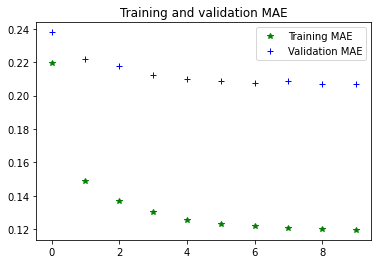

In [50]:

train_loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = np.arange(10)

plt.plot(epochs, train_loss, "g*", label="Training Mean Absolute Error")
plt.plot(epochs, val_loss, "b+", label="Validation Mean Absolute Error")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [51]:
model.evaluate(dataset_test)

493/493 [==============================] - 24s 48ms/step - loss: 0.2869 - mae: 0.4139


[0.2869442403316498, 0.41394343972206116]

### comments
- The dataset was split into test, train, and validation sets.
- Mean Absolute Error was used as the evaluation metric.
- RNN and GRUs were used for modelling.
- RNN had the problem of the vanishing gradient however, it has a better Mean Absolute Error when compared to the GRUs.